Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.


# SPADE LDM

In this tutorial, we apply SPADE normalisation [1] to a latent diffusion model, in a methodology initially published by Wang et al. [2] to perform semantic image synthesis. We apply to a subset of BraTS [3] that we registered to MNI space and resampled to 2mm isotropic space. Segmentations of cerebrospinal fluid, grey and white matter, deep grey matter and brainstem were obtained using Geodesic Information Flows (GIF) [4].

[1] Park, T., Liu, M.-Y., Wang, T.-C., & Zhu, J.-Y. (2019). Semantic Image Synthesis with Spatially-Adaptive Normalization. Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition.

[2] Wang, W., Bao, J., Zhou, W., Chen, D., Chen, D., Yuan, L., & Li, H. (2022). Semantic Image Synthesis via Diffusion Models. https://doi.org/10.48550/arxiv.2207.00050

[3] Menze, B. H., Jakab, A., Bauer, S., Kalpathy-Cramer, J., Farahani, K., Kirby, J., Burren, Y., Porz, N., Slotboom, J., Wiest, R., Lanczi, L., Gerstner, E., Weber, M.-A., Arbel, T., Avants, B. B., Ayache, N., Buendia, P., Collins, D. L., Cordier, N., … van Leemput, K. (2015). The Multimodal Brain Tumor Image Segmentation Benchmark (BRATS). IEEE Transactions on Medical Imaging, 34(10), 1993–2024. https://doi.org/10.1109/TMI.2014.2377694

[4] Cardoso, M. J., Wolz, R., Modat, M., Fox, N. C., Rueckert, D., & Ourselin, S. (2012). Geodesic information flows. Medical Image Computing and Computer-Assisted Intervention : MICCAI ...  International Conference on Medical Image Computing and Computer-Assisted Intervention, 15(Pt 2), 262–270. https://doi.org/10.1007/978-3-642-33418-4_33

## Setup environment 

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
!python -c "import gdown" || pip install -q gdown
%matplotlib inline

## Setup imports

In [ ]:
import os
import tempfile
import zipfile
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from torch.amp import GradScaler, autocast
import gdown
import monai
from monai.config import print_config
from monai.utils import set_determinism
from monai.data import DataLoader
from monai.networks.nets import SPADEAutoencoderKL, SPADEDiffusionModelUNet, PatchDiscriminator
from monai.networks.schedulers import DDPMScheduler
from monai.losses import PatchAdversarialLoss, PerceptualLoss
from monai.inferers import LatentDiffusionInferer

print_config()

## Setup a data directory

In [4]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
root_dir = Path(root_dir)
print("Temporary directory used: %s " % root_dir)

Temporary directory used: /tmp/tmpjboo3kuj 


## Set deterministic training for reproducibility

In [5]:
set_determinism(42)

## Description of the data and download dataset

The data for this notebook comes from the brain tumour segmentation challenge (BraTS) [2]. The images have been registered to MNI space using ANTsPy, and then subsampled to 2mm isotropic resolution. Geodesic Information Flows (GIF) [3] has been used to segment 5 regions: cerebrospinal fluid (CSF), grey matter (GM), white matter (WM), deep grey matter (DGM) and brainstem. Tumour sub-layers were delineated manually as part of the challenge source data. 
In this subset, we have only used one MRI modality , T1. 
Segmentations in this subset are merged and consist of the following labels: 0 (background), 1 (CSF), 2 (GM), 3 (WM), 4 (DGM), 5 (brainstem), 6 (brainstem), 7 (non GD-enahncing tumour core), 8 (peritumoural oedema), 9 (GD-enhancing tumour).


In [6]:
# Comment if already downloaded!
gdown.download("https://drive.google.com/uc?id=1q87a9euo52eoFG37shPK0G5juq20x7-m", os.path.join(root_dir, "data.zip"))
#!gdown -O data.zip "https://drive.google.com/uc?id=1q87a9euo52eoFG37shPK0G5juq20x7-m" --remaining-ok

Downloading...
From (original): https://drive.google.com/uc?id=1q87a9euo52eoFG37shPK0G5juq20x7-m
From (redirected): https://drive.google.com/uc?id=1q87a9euo52eoFG37shPK0G5juq20x7-m&confirm=t&uuid=2ffd42de-ac62-4c27-bb8d-8e96191deeb7
To: /tmp/tmpjboo3kuj/data.zip
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26.7M/26.7M [00:01<00:00, 26.7MB/s]


'/tmp/tmpjboo3kuj/data.zip'

We extract and reorganise the data into the relevant sub-folders:

In [7]:
zip_obj = zipfile.ZipFile(os.path.join(root_dir, "data.zip"), "r")
zip_obj.extractall(root_dir)
images_t1 = root_dir / "BRATS_SUBS2_SUBSET/T1"
labels = root_dir / "BRATS_SUBS2_SUBSET/Parcellations"

## Prepare dataloaders

In [8]:
# INPUT PARAMETERS
input_shape = [128, 128]
batch_size = 4
num_workers = 2

In [9]:
# We create the data dictionaries that we need
all_images = [os.path.join(images_t1, i) for i in os.listdir(images_t1)]
np.random.shuffle(all_images)
corresponding_labels = [
    os.path.join(labels, i.split("/")[-1].replace(i.split("/")[-1].split("_")[0], "Parcellation")) for i in all_images
]
input_dict = [{"image": i, "label": corresponding_labels[ind]} for ind, i in enumerate(all_images)]
input_dict_train = input_dict[: int(len(input_dict) * 0.9)]
input_dict_val = input_dict[int(len(input_dict) * 0.9) :]

We define the relevant transforms:
1. `LoadImaged`: to load the nii tumour images and labels
2. `EnsureChannelFirstd`: to make sure that a channel dimension is added on the tensors
3. `CenterSpatialCropd`: we ensure that the image and labels have the same shape
4. `RandSpatialCropd`: because we are extracting 2D slices from 3D volumes, we crop slices
5. `Resized`: to bring the shape of all images to the same value
6. `SqueezeDimd`: we remove the 1-dimension of the slice
7. `NormalizeIntensityd`: normalise the images
8. `RandBiasFieldd`: bias field augmentation
9. `RandAdjustContrastd`: random contrast augmentation
10. `RandGaussianNoised`: random noise tradition
11. `RandAffined`: random affine augmentation

In [10]:
preliminar_shape = input_shape + [50]  # We take random slices fron the center of the brain
crop_shape = input_shape + [1]
base_transforms = [
    monai.transforms.LoadImaged(keys=["label", "image"]),
    monai.transforms.EnsureChannelFirstd(keys=["image", "label"]),
    monai.transforms.CenterSpatialCropd(keys=["label", "image"], roi_size=preliminar_shape),
    monai.transforms.RandSpatialCropd(keys=["label", "image"], roi_size=crop_shape, max_roi_size=crop_shape),
    monai.transforms.SqueezeDimd(keys=["label", "image"], dim=-1),
    monai.transforms.Resized(keys=["image", "label"], spatial_size=input_shape),
]
last_transforms = [
    monai.transforms.CopyItemsd(keys=["label"], names=["label_channel"]),
    monai.transforms.Lambdad(keys=["label_channel"], func=lambda val: val != 0),
    monai.transforms.MaskIntensityd(keys=["image"], mask_key="label_channel"),
    monai.transforms.NormalizeIntensityd(keys=["image"]),
    monai.transforms.ToTensord(keys=["image", "label"]),
]

aug_transforms = [
    monai.transforms.RandBiasFieldd(coeff_range=(0, 0.005), prob=0.33, keys=["image"]),
    monai.transforms.RandAdjustContrastd(gamma=(0.9, 1.15), prob=0.33, keys=["image"]),
    monai.transforms.RandGaussianNoised(prob=0.33, mean=0.0, std=np.random.uniform(0.005, 0.015), keys=["image"]),
    monai.transforms.RandAffined(
        rotate_range=[-0.05, 0.05],
        shear_range=[0.001, 0.05],
        scale_range=[0, 0.05],
        padding_mode="zeros",
        mode="nearest",
        prob=0.33,
        keys=["label", "image"],
    ),
]

We create the dataset and dataloader:

In [11]:
train_transforms = monai.transforms.Compose(base_transforms + aug_transforms + last_transforms)
val_transforms = monai.transforms.Compose(base_transforms + last_transforms)

train_dataset = monai.data.dataset.Dataset(input_dict_train, train_transforms)
val_dataset = monai.data.dataset.Dataset(input_dict_val, val_transforms)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, num_workers=num_workers)
val_loader = DataLoader(val_dataset, shuffle=False, drop_last=False, batch_size=batch_size, num_workers=num_workers)

We do a sanity check and plot an element of the dataset:

torch.Size([4, 1, 128, 128])


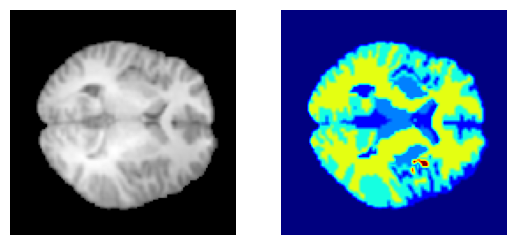

In [12]:
# Sanity check
batch = next(iter(train_loader))
print(batch["image"].shape)
plt.subplot(1, 2, 1)
plt.imshow(batch["image"][0, 0, ...], cmap="gist_gray")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(batch["label"][0, 0, ...], cmap="jet")
plt.axis("off")
plt.show()

### Networks creation and losses

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [14]:
def one_hot(input_label, label_nc):
    # One hot encoding function for the labels
    shape_ = list(input_label.shape)
    shape_[1] = label_nc
    label_out = torch.zeros(shape_)
    for channel in range(label_nc):
        label_out[:, channel, ...] = input_label[:, 0, ...] == channel
    return label_out

In [15]:
def picture_results(input_label, input_image, output_image):
    plt.figure(figsize=(4, 1.5))
    plt.subplot(1, 3, 1)
    plt.imshow(torch.argmax(input_label, 1)[0, ...].detach().cpu(), cmap="jet")
    plt.axis("off")
    plt.title("Label")
    plt.subplot(1, 3, 2)
    plt.imshow(input_image[0, 0, ...].detach().cpu(), cmap="gist_gray")
    plt.axis("off")
    plt.title("Input image")
    plt.subplot(1, 3, 3)
    plt.imshow(output_image[0, 0, ...].detach().cpu(), cmap="gist_gray")
    plt.axis("off")
    plt.title("Output image")
    plt.show()

SPADE Diffusion Models require two components:
- Autoencoder, incorporating SPADE normalisation in the decoder blocks
- Diffusion model, operating in the latent space, and incorporating SPADE normalisation in the decoding branch

In [16]:
autoencoder = SPADEAutoencoderKL(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    num_res_blocks=(2, 2, 2, 2),
    channels=(8, 16, 32, 64),
    attention_levels=[False, False, False, False],
    latent_channels=8,
    norm_num_groups=8,
    label_nc=6,
)

In [17]:
diffusion = SPADEDiffusionModelUNet(
    spatial_dims=2,
    in_channels=8,
    out_channels=8,
    num_res_blocks=(2, 2, 2, 2),
    channels=(16, 32, 64, 128),
    attention_levels=(False, False, True, True),
    norm_num_groups=16,
    with_conditioning=False,
    label_nc=6,
)

To train the autoencoder, we are using **a Patch-GAN-based adversarial loss**, a **perceptual loss** and a basic **L1 loss** between input and output.

In [ ]:
perceptual_loss = PerceptualLoss(spatial_dims=2, network_type="alex")
perceptual_loss.to(device)

In [23]:
discriminator = PatchDiscriminator(
    spatial_dims=2,
    num_layers_d=3,
    channels=16,
    in_channels=1,
    out_channels=1,
)
discriminator = discriminator.to(device)

adv_loss = PatchAdversarialLoss(criterion="least_squares")
adv_weight = 0.01

In [24]:
recon = torch.nn.L1Loss()

In [25]:
optimizer_g = torch.optim.Adam(autoencoder.parameters(), lr=0.0002)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=0.0004)
# For mixed precision training
scaler_g = torch.amp.GradScaler("cuda")
scaler_d = torch.amp.GradScaler("cuda")

## Training the AutoencoderKL

We used the exact same approach as the one from the 2d_ldm_tutorial to train the autoencoder.

In [26]:
# Loss weights and number of epochs
kl_weight = 1e-6
max_epochs = 100
val_interval = 20
adv_weights = 0.01
autoencoder_warm_up_n_epochs = 10
perceptual_weight = 0.001

Train: reconstruction: 0.039634; generator: 0.000000; discriminator: 0.000000; perceptual: 0.007687; kld: 815.478556
Train: reconstruction: 0.039850; generator: 0.000000; discriminator: 0.000000; perceptual: 0.006226; kld: 771.141073


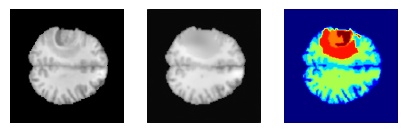

epoch 20 val loss: 0.0368
Train: reconstruction: 0.041205; generator: 0.272908; discriminator: 0.241269; perceptual: 0.006241; kld: 809.402791
Train: reconstruction: 0.037956; generator: 0.265336; discriminator: 0.235045; perceptual: 0.009201; kld: 799.378520


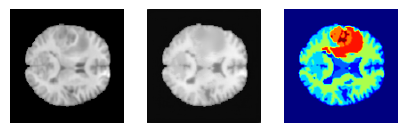

epoch 40 val loss: 0.0349
Train: reconstruction: 0.034912; generator: 0.319132; discriminator: 0.233328; perceptual: 0.004364; kld: 710.857808
Train: reconstruction: 0.037357; generator: 0.336117; discriminator: 0.262539; perceptual: 0.006409; kld: 724.309652


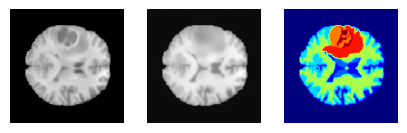

epoch 60 val loss: 0.0381
Train: reconstruction: 0.038877; generator: 0.258824; discriminator: 0.250337; perceptual: 0.007957; kld: 846.944326
Train: reconstruction: 0.034942; generator: 0.377081; discriminator: 0.269728; perceptual: 0.005779; kld: 795.518361


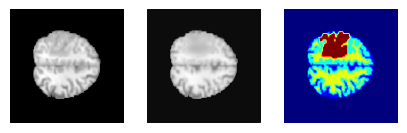

epoch 80 val loss: 0.0328
Train: reconstruction: 0.034282; generator: 0.324377; discriminator: 0.264228; perceptual: 0.005844; kld: 812.505910
Train: reconstruction: 0.035039; generator: 0.410919; discriminator: 0.214465; perceptual: 0.009735; kld: 733.619568


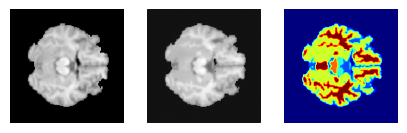

epoch 100 val loss: 0.0348


In [30]:
autoencoder.to(device)

# Loss storage
epoch_recon_losses = []
epoch_perc_losses = []
epoch_kld_losses = []
epoch_gen_losses = []
epoch_disc_losses = []
val_recon_losses = []

for epoch in range(max_epochs):
    autoencoder.train()
    discriminator.train()
    epoch_loss = 0
    gen_epoch_loss = 0
    disc_epoch_loss = 0
    perceptual_epoch_loss = 0
    kld_epoch_loss = 0
    for batch in train_loader:
        images = batch["image"].to(device)
        labels = one_hot(batch["label"], 6).to(device)
        optimizer_g.zero_grad(set_to_none=True)

        with autocast(device_type="cuda", enabled=True):
            reconstruction, z_mu, z_sigma = autoencoder(images, labels)
            recons_loss = recon(reconstruction.float(), images.float())
            p_loss = perceptual_loss(reconstruction.float(), images.float())
            kl_loss = 0.5 * torch.sum(z_mu.pow(2) + z_sigma.pow(2) - torch.log(z_sigma.pow(2)) - 1, dim=[1, 2, 3])
            kl_loss = torch.sum(kl_loss) / kl_loss.shape[0]
            loss_g = recons_loss + (kl_weight * kl_loss) + (perceptual_weight * p_loss)

            if epoch > autoencoder_warm_up_n_epochs:
                logits_fake = discriminator(reconstruction.contiguous().float())[-1]
                generator_loss = adv_loss(logits_fake, target_is_real=True, for_discriminator=False)
                loss_g += adv_weight * generator_loss

        scaler_g.scale(loss_g).backward()
        scaler_g.step(optimizer_g)
        scaler_g.update()

        if epoch > autoencoder_warm_up_n_epochs:
            with autocast(device_type="cuda", enabled=True):
                optimizer_d.zero_grad(set_to_none=True)
                logits_fake = discriminator(reconstruction.contiguous().detach())[-1]
                loss_d_fake = adv_loss(logits_fake, target_is_real=False, for_discriminator=True)
                logits_real = discriminator(images.contiguous().detach())[-1]
                loss_d_real = adv_loss(logits_real, target_is_real=True, for_discriminator=True)
                discriminator_loss = (loss_d_fake + loss_d_real) * 0.5

                loss_d = adv_weight * discriminator_loss

            scaler_d.scale(loss_d).backward()
            scaler_d.step(optimizer_d)
            scaler_d.update()

        epoch_loss += recons_loss.item()
        perceptual_epoch_loss += p_loss.item()
        kld_epoch_loss += kl_loss.item()
        if epoch > autoencoder_warm_up_n_epochs:
            gen_epoch_loss += generator_loss.item()
            disc_epoch_loss += discriminator_loss.item()

    num_steps = len(train_loader) + 1
    epoch_recon_losses.append(epoch_loss / num_steps)
    epoch_gen_losses.append(gen_epoch_loss / num_steps)
    epoch_disc_losses.append(disc_epoch_loss / num_steps)
    epoch_perc_losses.append(p_loss / num_steps)
    epoch_kld_losses.append(kld_epoch_loss / num_steps)

    if epoch % 10 == 0:
        msgs = [
            f"Train: reconstruction: {epoch_recon_losses[-1]:4f}",
            f" generator: {epoch_gen_losses[-1]:4f}",
            f" discriminator: {epoch_disc_losses[-1]:4f}",
            f" perceptual: {epoch_perc_losses[-1]:4f}",
            f" kld: {epoch_kld_losses[-1]:4f}",
        ]
        print(";".join(msgs))

    if (epoch + 1) % val_interval == 0:
        autoencoder.eval()
        val_loss = 0
        with torch.no_grad():
            for val_step, batch in enumerate(val_loader, start=0):
                images = batch["image"].to(device)
                labels = one_hot(batch["label"], 6).to(device)
                with autocast(device_type="cuda", enabled=True):
                    reconstruction, z_mu, z_sigma = autoencoder(images, labels)
                    recons_loss = recon(images.float(), reconstruction.float())
                val_loss += recons_loss.item()
                # We retrieve the image to plot
                if val_step == 0:
                    reconstruction = reconstruction.detach().cpu()
                    plt.figure(figsize=(5, 3))
                    plt.subplot(1, 3, 1)
                    plt.imshow(images[0, 0, ...].detach().cpu(), cmap="gist_gray")
                    plt.axis("off")
                    plt.subplot(1, 3, 2)
                    plt.imshow(reconstruction[0, 0, ...], cmap="gist_gray")
                    plt.axis("off")
                    plt.subplot(1, 3, 3)
                    plt.imshow(batch["label"][0, 0, ...].detach().cpu(), cmap="jet")
                    plt.axis("off")
                    plt.show()

        val_loss /= max(val_step, 1)
        val_recon_losses.append(val_loss)
        print(f"epoch {epoch + 1} val loss: {val_loss:.4f}")

del discriminator
del perceptual_loss
torch.cuda.empty_cache()

## Training the diffusion model

Likewise, we use the same approach as in the 2d_ldm_tutorial.

In [31]:
scheduler = DDPMScheduler(num_train_timesteps=1000, schedule="linear_beta", beta_start=0.0015, beta_end=0.0195)
optimizer = torch.optim.Adam(diffusion.parameters(), lr=1e-4)
inferer = LatentDiffusionInferer(scheduler, scale_factor=1.0)

Epoch 0 / 200


training loss: 1.0034
Epoch 10 / 200
training loss: 0.9315
Epoch 20 / 200
training loss: 0.8709
Epoch 30 / 200
training loss: 0.8102


Epoch 39 val loss: 0.7840


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:23<00:00, 42.05it/s]


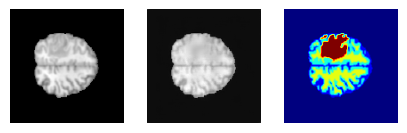

Epoch 40 / 200
training loss: 0.7813
Epoch 50 / 200
training loss: 0.7013
Epoch 60 / 200
training loss: 0.6907
Epoch 70 / 200
training loss: 0.6525
Epoch 79 val loss: 0.5309


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:25<00:00, 39.09it/s]


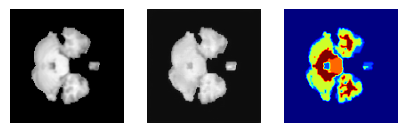

Epoch 80 / 200
training loss: 0.6065
Epoch 90 / 200
training loss: 0.4917
Epoch 100 / 200
training loss: 0.4911
Epoch 110 / 200
training loss: 0.5587
Epoch 119 val loss: 0.4845


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:24<00:00, 40.34it/s]


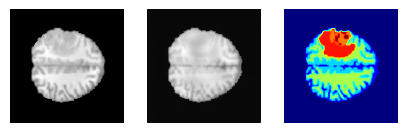

Epoch 120 / 200
training loss: 0.4899
Epoch 130 / 200
training loss: 0.4610
Epoch 140 / 200
training loss: 0.4903
Epoch 150 / 200
training loss: 0.3912
Epoch 159 val loss: 0.4990


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:25<00:00, 39.23it/s]


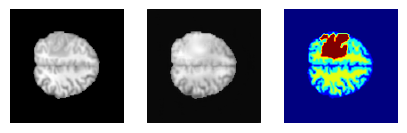

Epoch 160 / 200
training loss: 0.4311
Epoch 170 / 200
training loss: 0.4064
Epoch 180 / 200
training loss: 0.3768
Epoch 190 / 200
training loss: 0.3853
Epoch 199 val loss: 0.2768


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:25<00:00, 39.72it/s]


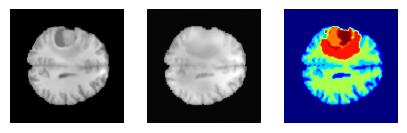

In [33]:
diffusion = diffusion.to(device)
max_epochs = 200
val_interval = 40
epoch_losses = []
val_losses = []
scaler = GradScaler("cuda")

for epoch in range(max_epochs):
    if epoch % 10 == 0:
        print("Epoch %d / %d" % (epoch, max_epochs))
    diffusion.train()
    autoencoder.eval()
    epoch_loss = 0
    for batch in train_loader:
        images = batch["image"].to(device)
        labels = one_hot(batch["label"], 6).to(device)
        optimizer.zero_grad(set_to_none=True)
        with autocast(device_type="cuda", enabled=True):
            z_mu, z_sigma = autoencoder.encode(images)
            z = autoencoder.sampling(z_mu, z_sigma)
            noise = torch.randn_like(z).to(device)
            timesteps = torch.randint(0, inferer.scheduler.num_train_timesteps, (z.shape[0],), device=z.device).long()
            noise_pred = inferer(
                inputs=images,
                diffusion_model=diffusion,
                noise=noise,
                timesteps=timesteps,
                autoencoder_model=autoencoder,
                seg=labels,
            )
            loss = F.mse_loss(noise_pred.float(), noise.float())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()

    epoch_losses.append(epoch_loss / (len(train_loader) + 1))
    if epoch % 10 == 0:
        print("training loss: %.4f" % (epoch_losses[-1]))

    if (epoch + 1) % val_interval == 0:
        diffusion.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                images = batch["image"].to(device)
                labels = one_hot(batch["label"], 6).to(device)
                with autocast(device_type="cuda", enabled=True):
                    z_mu, z_sigma = autoencoder.encode(images)

                    z = autoencoder.sampling(z_mu, z_sigma)
                    noise = torch.randn_like(z).to(device)
                    timesteps = torch.randint(
                        0, inferer.scheduler.num_train_timesteps, (z.shape[0],), device=z.device
                    ).long()
                    noise_pred = inferer(
                        inputs=images,
                        diffusion_model=diffusion,
                        noise=noise,
                        timesteps=timesteps,
                        autoencoder_model=autoencoder,
                        seg=labels,
                    )

                    loss = F.mse_loss(noise_pred.float(), noise.float())

                val_loss += loss.item()
        val_loss /= len(val_loader) + 1
        val_losses.append(val_loss)
        print(f"Epoch {epoch} val loss: {val_loss:.4f}")

        # Sampling image during training. We use the last segmentation of our loader
        z = torch.randn((labels.shape[0], 8, 16, 16))
        z = z.to(device)
        scheduler.set_timesteps(num_inference_steps=1000)
        with autocast(device_type="cuda", enabled=True):
            decoded = inferer.sample(
                input_noise=z, diffusion_model=diffusion, scheduler=scheduler, autoencoder_model=autoencoder, seg=labels
            )
        plt.figure(figsize=(5, 3))
        plt.subplot(1, 3, 1)
        plt.imshow(images[0, 0, ...].detach().cpu(), cmap="gist_gray")
        plt.axis("off")
        plt.subplot(1, 3, 2)
        plt.imshow(decoded[0, 0, ...].detach().cpu(), cmap="gist_gray")
        plt.axis("off")
        plt.subplot(1, 3, 3)
        plt.imshow(batch["label"][0, 0, ...].detach().cpu(), cmap="jet")
        plt.axis("off")
        plt.show()